### Imports

In [1]:
from pykeen.pipeline import pipeline

from pykeen.models import TransE
from pykeen.models import predict

from pykeen.datasets import Nations
from pykeen.datasets import YAGO310

from pykeen.models.predict import get_relation_prediction_df
from pykeen.models.predict import get_all_prediction_df

from pykeen.datasets.analysis import get_relation_count_df
from pykeen.datasets.analysis import get_entity_count_df
#from pykeen.datasets.analysis import get_relation_functionality_df
#from pykeen.datasets.analysis import get_entity_relation_co_occurrence_df
from pykeen.datasets.analysis import get_relation_pattern_types_df

from pykeen.triples.triples_factory import tensor_to_df
from pykeen.triples.triples_factory import CoreTriplesFactory

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from collections import Counter

import scipy.stats as stats

C:\Users\tommy\anaconda3\envs\ThesisLaptop\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Exploration

In [2]:
dataset = Nations()

In [3]:
print(dataset)

Nations(num_entities=14, num_relations=55, create_inverse_triples=False)


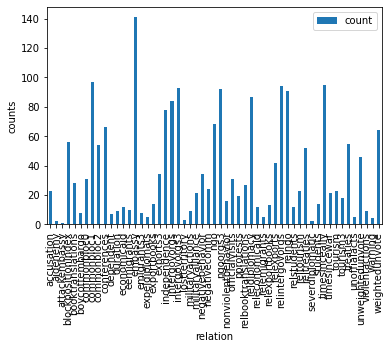

In [4]:
relation_count = get_relation_count_df(dataset)

ax = relation_count.plot.bar(x='relation_label', y='count', rot=90)
ax.set_xlabel("relation")
ax.set_ylabel("counts")

plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]=10,10

    entity_id  count entity_label
0           0    260       brazil
1           1    146        burma
2           2    249        china
3           3    232         cuba
4           4    284        egypt
5           5    302        india
6           6    215    indonesia
7           7    243       israel
8           8    146       jordan
9           9    313  netherlands
10         10    287       poland
11         11    462           uk
12         12    514          usa
13         13    331         ussr


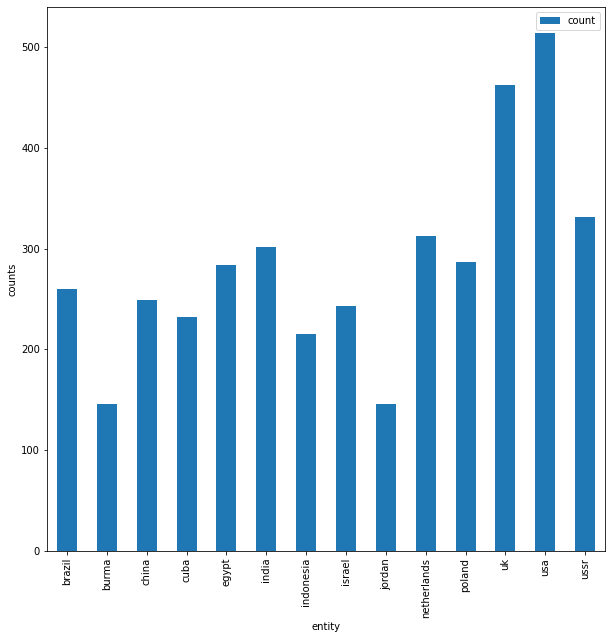

In [5]:
entity_count = get_entity_count_df(dataset)

print(entity_count)

ax = entity_count.plot.bar(x='entity_label', y='count', rot=90)
ax.set_xlabel("entity")
ax.set_ylabel("counts")

plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]=10,10

In [6]:
relation_pattern = get_relation_pattern_types_df(dataset)

relation_pattern['pattern'].value_counts()


Checking ternary patterns: 100%|██████████| 2.92k/2.92k [00:00<00:00, 8.10kpattern/s]


composition      57
symmetry         13
anti-symmetry    10
inversion         4
Name: pattern, dtype: int64

### Loading TransE

In [7]:
from pykeen.pipeline import pipeline
pipeline_result = pipeline(
    dataset= dataset,
    model= TransE,
    training_loop='sLCWA',
    negative_sampler='basic',
    evaluator='RankBasedEvaluator',
    training_kwargs=dict(num_epochs=128),
    random_seed = 3757357109,
    #result_tracker='mlflow',
    #result_tracker_kwargs=dict(
        #tracking_uri='http://localhost:5000',
        #experiment_name='Training of TransE on Nations',
    #),
    device='cpu'
)
pipeline_result.save_to_directory(r'C:\Users\tommy\OneDrive\Documenten\year 3\Bachelor AI Project\coding')

#seed 3757357109

C:\Users\tommy\anaconda3\envs\ThesisLaptop\lib\site-packages\pykeen\nn\representation.py:372: UserWarning: Directly use Embedding.max_id instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.max_id instead of num_embeddings.")
Training epochs on cpu:  34%|███▍      | 44/128 [00:03<00:07, 11.28epoch/s, loss=0.00444, prev_loss=0.00425]


Training epochs on cpu:  70%|███████   | 90/128 [00:08<00:03, 10.77epoch/s, loss=0.00349, prev_loss=0.00357]


Training epochs on cpu: 100%|██████████| 128/128 [00:11<00:00, 11.17epoch/s, loss=0.00313, prev_loss=0.00314]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|██████████| 201/201 [00:00<00:00, 9.38ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14, num_relations=55, num_triples=1592, inverse_triples=False, path="C:\Users\tommy\anaconda3\envs\ThesisLaptop\Lib\site-packages\pykeen\datasets\nations\train.txt") to file:///C:/Users/tommy/OneDrive/Documenten/year%203/Bachelor%20AI%20Project/coding/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///C:/Users/tommy/OneDrive/Documenten/year%203/Bachelor%20AI%20Project/coding


In [8]:
print(pipeline_result)

PipelineResult(random_seed=3757357109, model=TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(14, 50)
  )
  (relation_embeddings): Embedding(
    (_embeddings): Embedding(55, 50)
  )
), training=TriplesFactory(num_entities=14, num_relations=55, num_triples=1592, inverse_triples=False, path="C:\Users\tommy\anaconda3\envs\ThesisLaptop\Lib\site-packages\pykeen\datasets\nations\train.txt"), training_loop=<pykeen.training.slcwa.SLCWATrainingLoop object at 0x0000020AF232D150>, losses=[0.006556272656474281, 0.00641097824777191, 0.006227484749789214, 0.006223661815700819, 0.005883641728204698, 0.006201163907745975, 0.005719204119701482, 0.005885766678719065, 0.005678910181750005, 0.005425209076560323, 0.005586392690787962, 0.005410507920399383, 0.005439016986731908, 0.005416184139611134, 0.005328993327054546, 0.005171818050307844, 0.005284221552724215, 0.004933478469824671, 0

In [9]:
mapped_triples = dataset.training.mapped_triples
print(mapped_triples)

tensor([[ 0,  3,  2],
        [ 0,  3,  3],
        [ 0,  3, 10],
        ...,
        [13, 54,  9],
        [13, 54, 11],
        [13, 54, 12]])


In [10]:
print(pipeline_result.model.loss_default_kwargs)

{'margin': 1.0, 'reduction': 'mean'}


(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <AxesSubplot:title={'center':'Entity/Relation Plot using PCA'}>],
       dtype=object))

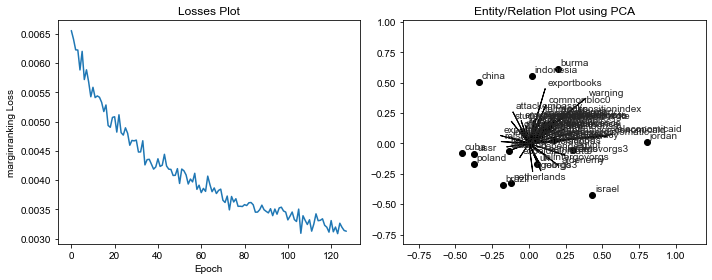

In [11]:
pipeline_result.plot()

### Loading Link Prediction Model

In [12]:
df = get_relation_prediction_df(pipeline_result.model, 'brazil', 'uk', triples_factory=pipeline_result.training)

In [13]:
print(pipeline_result.training)

TriplesFactory(num_entities=14, num_relations=55, num_triples=1592, inverse_triples=False, path="C:\Users\tommy\anaconda3\envs\ThesisLaptop\Lib\site-packages\pykeen\datasets\nations\train.txt")


In [14]:
df.head()

,relation_id,relation_label,score,in_training
8,8,commonbloc2,-8.504730,True
37,37,relexports,-8.626932,True
18,18,exports3,-8.731749,True
4,4,booktranslations,-8.767905,True
33,33,reldiplomacy,-8.800829,True


In [15]:
print(df[['relation_label', 'score']])

         relation_label      score
8           commonbloc2  -8.504730
37           relexports  -8.626932
18             exports3  -8.731749
4      booktranslations  -8.767905
33         reldiplomacy  -8.800829
51     unweightedunvote  -8.826662
6           commonbloc0  -8.884318
19         independence  -9.074988
45        timesinceally  -9.090645
38      relintergovorgs  -9.172159
42          reltreaties  -9.204748
27                  ngo  -9.209888
32  relbooktranslations  -9.216327
24     militaryalliance  -9.271112
29   nonviolentbehavior  -9.298793
43      severdiplomatic  -9.313442
26         negativecomm  -9.319839
49             treaties  -9.405924
5        boycottembargo  -9.458890
0            accusation  -9.463378
44             students  -9.475283
28             ngoorgs3  -9.493158
20         intergovorgs  -9.493661
39               relngo  -9.513278
3    blockpositionindex  -9.534028
11             duration  -9.538947
9           conferences  -9.587495
16       expeldiplom

In [16]:
top_df = get_all_prediction_df(pipeline_result.model, k=10780, remove_known=True,  triples_factory=pipeline_result.training)

scoring: 100%|██████████| 770/770 [00:00<00:00, 2.63kbatch/s]


In [17]:
top_df.head()

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,13,ussr,46,timesincewar,13,ussr,-7.551423
1,0,brazil,46,timesincewar,0,brazil,-7.551423
2,4,egypt,46,timesincewar,4,egypt,-7.551423
3,8,jordan,46,timesincewar,8,jordan,-7.551424
4,5,india,46,timesincewar,5,india,-7.551424


In [18]:
top_df.iloc[::-1]

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
10779,8,jordan,12,economicaid,13,ussr,-14.249941
10778,7,israel,12,economicaid,2,china,-14.245221
10777,8,jordan,34,releconomicaid,13,ussr,-13.999825
10776,8,jordan,12,economicaid,10,poland,-13.846768
10775,7,israel,34,releconomicaid,2,china,-13.768528
...,...,...,...,...,...,...,...
4,5,india,46,timesincewar,5,india,-7.551424
3,8,jordan,46,timesincewar,8,jordan,-7.551424
2,4,egypt,46,timesincewar,4,egypt,-7.551423
1,0,brazil,46,timesincewar,0,brazil,-7.551423


In [19]:
top_df.iloc[9187]

head_id                     8
head_label             jordan
relation_id                12
relation_label    economicaid
tail_id                    13
tail_label               ussr
score              -14.249941
Name: 10779, dtype: object

In [20]:
top_df = top_df.reset_index(drop=True)

In [21]:
print(top_df[['head_label', 'relation_label', 'tail_label', 'score', ]])

     head_label  relation_label tail_label      score
0          ussr    timesincewar       ussr  -7.551423
1        brazil    timesincewar     brazil  -7.551423
2         egypt    timesincewar      egypt  -7.551423
3        jordan    timesincewar     jordan  -7.551424
4         india    timesincewar      india  -7.551424
...         ...             ...        ...        ...
9183     israel  releconomicaid      china -13.768528
9184     jordan     economicaid     poland -13.846768
9185     jordan  releconomicaid       ussr -13.999825
9186     israel     economicaid      china -14.245221
9187     jordan     economicaid       ussr -14.249941

[9188 rows x 4 columns]


In [22]:
top_df_uk_brazil = top_df.loc[(top_df['head_label'] == 'uk') & (top_df['tail_label'] == 'brazil') | (top_df['head_label'] == 'brazil') & (top_df['tail_label'] == 'uk')]

In [23]:
print(top_df_uk_brazil)

      head_id head_label  relation_id    relation_label  tail_id tail_label  \
886         0     brazil            6       commonbloc0       11         uk   
1009       11         uk           48          tourism3        0     brazil   
1056       11         uk           31         pprotests        0     brazil   
1135       11         uk           22     lostterritory        0     brazil   
1222       11         uk           30    officialvisits        0     brazil   
...       ...        ...          ...               ...      ...        ...   
8078       11         uk            4  booktranslations        0     brazil   
8203       11         uk           43   severdiplomatic        0     brazil   
8426        0     brazil           12       economicaid       11         uk   
8730        0     brazil           34    releconomicaid       11         uk   
8846       11         uk           44          students        0     brazil   

          score  
886   -8.884318  
1009  -9.059093

In [24]:
sameHeadTail_df = top_df[top_df[['head_label','tail_label']].nunique(axis=1) == 1]
print(sameHeadTail_df)

      head_id head_label  relation_id relation_label  tail_id tail_label  \
0          13       ussr           46   timesincewar       13       ussr   
1           0     brazil           46   timesincewar        0     brazil   
2           4      egypt           46   timesincewar        4      egypt   
3           8     jordan           46   timesincewar        8     jordan   
4           5      india           46   timesincewar        5      india   
...       ...        ...          ...            ...      ...        ...   
1175        3       cuba           35   relemigrants        3       cuba   
1176        1      burma           35   relemigrants        1      burma   
1177        0     brazil           35   relemigrants        0     brazil   
1178       13       ussr           35   relemigrants       13       ussr   
1179        2      china           35   relemigrants        2      china   

         score  
0    -7.551423  
1    -7.551423  
2    -7.551423  
3    -7.551424  
4 

In [25]:
#[i for i, j in zip(top_df['head_label'], top_df['tail_label']) if i == j]

Dataframe of all predictions where h != t in hrt

In [26]:
DifferentHeadTail_df = top_df.loc[top_df['head_label'] != top_df['tail_label']]

In [27]:
print(DifferentHeadTail_df)

      head_id   head_label  relation_id  relation_label  tail_id tail_label  \
168         9  netherlands           31       pprotests        0     brazil   
197        10       poland           48        tourism3       13       ussr   
226         1        burma           16  expeldiplomats       10     poland   
269        12          usa           46    timesincewar       11         uk   
298        13         ussr           50    unoffialacts       11         uk   
...       ...          ...          ...             ...      ...        ...   
9183        7       israel           34  releconomicaid        2      china   
9184        8       jordan           12     economicaid       10     poland   
9185        8       jordan           34  releconomicaid       13       ussr   
9186        7       israel           12     economicaid        2      china   
9187        8       jordan           12     economicaid       13       ussr   

          score  
168   -7.899419  
197   -7.913929

In [28]:
DifferentHeadTail_df.loc[(DifferentHeadTail_df['head_label'] == 'brazil') & (DifferentHeadTail_df['tail_label'] == 'uk')]


,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
886,0,brazil,6,commonbloc0,11,uk,-8.884318
1283,0,brazil,24,militaryalliance,11,uk,-9.271112
1324,0,brazil,29,nonviolentbehavior,11,uk,-9.298793
1351,0,brazil,43,severdiplomatic,11,uk,-9.313442
1360,0,brazil,26,negativecomm,11,uk,-9.319839
1501,0,brazil,49,treaties,11,uk,-9.405924
1598,0,brazil,5,boycottembargo,11,uk,-9.458890
1608,0,brazil,0,accusation,11,uk,-9.463378
1629,0,brazil,44,students,11,uk,-9.475283
1763,0,brazil,3,blockpositionindex,11,uk,-9.534028


### Model to iteratively go through all non-existing links for link prediction task

change sampling strategy

5050 chance of using the normal sample or the specific triple

to assume a link as true or false -> change tripleFactory in training the pipeline model?

In [29]:
model = pipeline_result.model

 Relational Link Prediction task between "brazil" and "uk"

In [30]:
relationPrediction_df_BrUk = get_relation_prediction_df(model,'brazil', 'uk', add_novelties=True ,triples_factory=pipeline_result.training)

In [31]:
relationPrediction_df_BrUk.head()

,relation_id,relation_label,score,in_training
8,8,commonbloc2,-8.504730,True
37,37,relexports,-8.626932,True
18,18,exports3,-8.731749,True
4,4,booktranslations,-8.767905,True
33,33,reldiplomacy,-8.800829,True


In [32]:
score_df = predict.predict_triples_df(
    model=model,
    triples=[('brazil', 'conferences', 'uk'), ('brazil', 'intergovorgs', 'uk')],
    triples_factory=pipeline_result.training,)

In [33]:
print(score_df[["head_label", "relation_label", "tail_label", "score"]])

  head_label relation_label tail_label     score
0     brazil    conferences         uk -9.587495
1     brazil   intergovorgs         uk -9.493661


##### Iterate through all novel triples to predict all their relations

In [34]:
unique_Nations = entity_count.copy()

Nations_combinations_list = []

for head in unique_Nations['entity_label']:
    for tail in unique_Nations['entity_label']:
        if head == tail:
            continue
        Nations_combinations_list.append([head, tail])
    

#to get onesided combinations:
'''
for i in Nations_combinations_list:
    for j in Nations_combinations_list:
        if i[0] == j[1] and i[1] == j[0]:
            Nations_combinations_list.remove(i)
'''

print("unique nations combinations list: ","\n",Nations_combinations_list)
print(" ")
print("length of unique nations combinations list: ", len(Nations_combinations_list))

unique nations combinations list:  
 [['brazil', 'burma'], ['brazil', 'china'], ['brazil', 'cuba'], ['brazil', 'egypt'], ['brazil', 'india'], ['brazil', 'indonesia'], ['brazil', 'israel'], ['brazil', 'jordan'], ['brazil', 'netherlands'], ['brazil', 'poland'], ['brazil', 'uk'], ['brazil', 'usa'], ['brazil', 'ussr'], ['burma', 'brazil'], ['burma', 'china'], ['burma', 'cuba'], ['burma', 'egypt'], ['burma', 'india'], ['burma', 'indonesia'], ['burma', 'israel'], ['burma', 'jordan'], ['burma', 'netherlands'], ['burma', 'poland'], ['burma', 'uk'], ['burma', 'usa'], ['burma', 'ussr'], ['china', 'brazil'], ['china', 'burma'], ['china', 'cuba'], ['china', 'egypt'], ['china', 'india'], ['china', 'indonesia'], ['china', 'israel'], ['china', 'jordan'], ['china', 'netherlands'], ['china', 'poland'], ['china', 'uk'], ['china', 'usa'], ['china', 'ussr'], ['cuba', 'brazil'], ['cuba', 'burma'], ['cuba', 'china'], ['cuba', 'egypt'], ['cuba', 'india'], ['cuba', 'indonesia'], ['cuba', 'israel'], ['cuba', '

#### Model to iteratively go through all unique h-t combinations to predict scores for all relations

In [35]:
dataframes = []
entity_tails = []

for i in Nations_combinations_list:
    pred_df = get_relation_prediction_df(model, i[0], i[1], add_novelties=True ,triples_factory=pipeline_result.training)
    dataframes.append(pred_df)
    entity_tails.append([i[0], i[1]])
    
result = pd.concat(dataframes)



In [36]:
print("amount of triples ", len(result))
print("amount of head tail combinations: ", len(Nations_combinations_list))
print("amount of relations predicted per head: ", len(result)/len(Nations_combinations_list))

amount of triples  10010
amount of head tail combinations:  182
amount of relations predicted per head:  55.0


In [37]:
temp_list1 = []
temp_list2 = []
for i in Nations_combinations_list:
    for j in range(55):
        temp_list1.append(i[0])
        temp_list2.append(i[1])
        

In [38]:
result['head'] = temp_list1
result['tail'] = temp_list2

In [39]:
result = result.reset_index(drop=True)

In [40]:
print(Nations_combinations_list.index(['uk', 'brazil']) * 55)

7865


In [41]:
print(result.head())

   relation_id    relation_label      score  in_training    head   tail
0            5    boycottembargo -10.013790        False  brazil  burma
1           42       reltreaties -10.090649        False  brazil  burma
2           27               ngo -10.103390        False  brazil  burma
3            7       commonbloc1 -10.137999         True  brazil  burma
4           51  unweightedunvote -10.166827        False  brazil  burma


In [42]:
result_uk_brazil_df = result.loc[(result['head'] == 'uk') & (result['tail'] == 'brazil') | (result['head'] == 'brazil') & (result['tail'] == 'uk')]

In [43]:
print(result_uk_brazil_df) 

      relation_id       relation_label      score  in_training    head    tail
550             8          commonbloc2  -8.504730         True  brazil      uk
551            37           relexports  -8.626932         True  brazil      uk
552            18             exports3  -8.731749         True  brazil      uk
553             4     booktranslations  -8.767905         True  brazil      uk
554            33         reldiplomacy  -8.800829         True  brazil      uk
...           ...                  ...        ...          ...     ...     ...
7915           18             exports3 -11.063818        False      uk  brazil
7916           32  relbooktranslations -11.077889        False      uk  brazil
7917            4     booktranslations -11.431761        False      uk  brazil
7918           43      severdiplomatic -11.515512        False      uk  brazil
7919           44             students -12.076553        False      uk  brazil

[110 rows x 6 columns]


In [44]:
print(result_uk_brazil_df[result_uk_brazil_df['head'] == 'brazil']) 

     relation_id       relation_label      score  in_training    head tail
550            8          commonbloc2  -8.504730         True  brazil   uk
551           37           relexports  -8.626932         True  brazil   uk
552           18             exports3  -8.731749         True  brazil   uk
553            4     booktranslations  -8.767905         True  brazil   uk
554           33         reldiplomacy  -8.800829         True  brazil   uk
555           51     unweightedunvote  -8.826662         True  brazil   uk
556            6          commonbloc0  -8.884318        False  brazil   uk
557           19         independence  -9.074988         True  brazil   uk
558           45        timesinceally  -9.090645         True  brazil   uk
559           38      relintergovorgs  -9.172159         True  brazil   uk
560           42          reltreaties  -9.204748         True  brazil   uk
561           27                  ngo  -9.209888         True  brazil   uk
562           32  relbook

In [45]:
counter = 0
for i in result['relation_label']:
    if i == 'unweightedunvote':
        counter += 1

print(counter)

182


result dataframe from manually predicting all relations of all possible head-tail combinations has more rows than top_df dataframe.

Need to test which relations are missing in the top_df relations

In [46]:
compared_diff = list(set(result_uk_brazil_df['relation_label']) - set(top_df_uk_brazil['relation_label']))
print((compared_diff))
compared = list(set(result_uk_brazil_df['relation_label']) & set(top_df_uk_brazil['relation_label']))
print(compared)

['ngo', 'timesinceally', 'unweightedunvote', 'intergovorgs', 'weightedunvote', 'ngoorgs3', 'commonbloc2']
['duration', 'blockpositionindex', 'relexports', 'releconomicaid', 'conferences', 'relbooktranslations', 'militaryalliance', 'tourism3', 'severdiplomatic', 'embassy', 'aidenemy', 'relintergovorgs', 'reltreaties', 'reldiplomacy', 'boycottembargo', 'relexportbooks', 'emigrants3', 'militaryactions', 'violentactions', 'lostterritory', 'warning', 'economicaid', 'intergovorgs3', 'independence', 'booktranslations', 'students', 'accusation', 'timesincewar', 'unoffialacts', 'pprotests', 'reltourism', 'relngo', 'tourism', 'eemigrants', 'officialvisits', 'relemigrants', 'nonviolentbehavior', 'commonbloc1', 'negativebehavior', 'expeldiplomats', 'exportbooks', 'treaties', 'exports3', 'dependent', 'commonbloc0', 'relstudents', 'attackembassy', 'negativecomm']


In [47]:
relation_top_df = list(top_df_uk_brazil['relation_label'])
relation_result = list(result_uk_brazil_df['relation_label'])

In [48]:
print(len(relation_top_df))
print(len(relation_result))

82
110


In [49]:
for i in top_df_uk_brazil["relation_label"]:
    print(i)
print(len(top_df_uk_brazil["relation_label"]))

commonbloc0
tourism3
pprotests
lostterritory
officialvisits
militaryalliance
nonviolentbehavior
severdiplomatic
negativecomm
intergovorgs3
blockpositionindex
treaties
violentactions
boycottembargo
accusation
students
commonbloc1
blockpositionindex
conferences
duration
militaryactions
conferences
expeldiplomats
militaryactions
timesincewar
officialvisits
dependent
commonbloc0
eemigrants
unoffialacts
tourism
treaties
reldiplomacy
embassy
commonbloc1
tourism
negativebehavior
emigrants3
nonviolentbehavior
negativecomm
independence
releconomicaid
relintergovorgs
relstudents
negativebehavior
militaryalliance
economicaid
violentactions
accusation
relngo
emigrants3
reltreaties
expeldiplomats
warning
attackembassy
aidenemy
warning
attackembassy
timesincewar
eemigrants
dependent
relemigrants
unoffialacts
reltourism
pprotests
tourism3
relexports
relexportbooks
lostterritory
relemigrants
duration
aidenemy
relstudents
exportbooks
boycottembargo
exports3
relbooktranslations
booktranslations
severdip

In [50]:
import collections
duplicates = ([item for item, count in collections.Counter(top_df_uk_brazil["relation_label"]).items() if count > 1])
print(len(duplicates))
print(duplicates)

34
['commonbloc0', 'tourism3', 'pprotests', 'lostterritory', 'officialvisits', 'militaryalliance', 'nonviolentbehavior', 'severdiplomatic', 'negativecomm', 'blockpositionindex', 'treaties', 'violentactions', 'boycottembargo', 'accusation', 'students', 'commonbloc1', 'conferences', 'duration', 'militaryactions', 'expeldiplomats', 'timesincewar', 'dependent', 'eemigrants', 'unoffialacts', 'tourism', 'negativebehavior', 'emigrants3', 'releconomicaid', 'relstudents', 'economicaid', 'warning', 'attackembassy', 'aidenemy', 'relemigrants']


In [51]:
print(result)

       relation_id    relation_label      score  in_training    head   tail
0                5    boycottembargo -10.013790        False  brazil  burma
1               42       reltreaties -10.090649        False  brazil  burma
2               27               ngo -10.103390        False  brazil  burma
3                7       commonbloc1 -10.137999         True  brazil  burma
4               51  unweightedunvote -10.166827        False  brazil  burma
...            ...               ...        ...          ...     ...    ...
10005           34    releconomicaid -10.524947        False    ussr    usa
10006           47           tourism -10.587654        False    ussr    usa
10007           11          duration -10.651754        False    ussr    usa
10008           36    relexportbooks -10.727164        False    ussr    usa
10009           43   severdiplomatic -11.476024        False    ussr    usa

[10010 rows x 6 columns]


In [52]:
triples_not_in_training = result[result['in_training'] == False]
triples_not_in_training

,relation_id,relation_label,score,in_training,head,tail
0,5,boycottembargo,-10.013790,False,brazil,burma
1,42,reltreaties,-10.090649,False,brazil,burma
2,27,ngo,-10.103390,False,brazil,burma
4,51,unweightedunvote,-10.166827,False,brazil,burma
5,8,commonbloc2,-10.171831,False,brazil,burma
...,...,...,...,...,...,...
10005,34,releconomicaid,-10.524947,False,ussr,usa
10006,47,tourism,-10.587654,False,ussr,usa
10007,11,duration,-10.651754,False,ussr,usa
10008,36,relexportbooks,-10.727164,False,ussr,usa


### Assume links as true or false

In [53]:
print(pipeline_result.training)

TriplesFactory(num_entities=14, num_relations=55, num_triples=1592, inverse_triples=False, path="C:\Users\tommy\anaconda3\envs\ThesisLaptop\Lib\site-packages\pykeen\datasets\nations\train.txt")


In [57]:
score_df = predict.predict_triples_df(
    model=model,
    triples=[('brazil', 'conferences', 'uk')],
    triples_factory=pipeline_result.training,)

In [58]:
score_df

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,0,brazil,9,conferences,11,uk,-9.587495


Assmumption of link being true

In [55]:
new_loss_function_true = 

SyntaxError: invalid syntax (298382129.py, line 1)

In [56]:
pipeline_result_true = pipeline(
    dataset= dataset,
    model= TransE,
    loss= new_loss_function_true
    training_loop='sLCWA',
    negative_sampler='basic',
    evaluator='RankBasedEvaluator',
    training_kwargs=dict(num_epochs=128),
    random_seed = 3757357109,
    #result_tracker='mlflow',
    #result_tracker_kwargs=dict(
        #tracking_uri='http://localhost:5000',
        #experiment_name='Training of TransE on Nations',
    #),
    device='cpu'
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3837717943.py, line 4)

Assumption of link being false

In [ ]:
new_loss_function_false = 

In [ ]:
pipeline_result_true = pipeline(
    dataset= dataset,
    model= TransE,
    loss= new_loss_function_true
    training_loop='sLCWA',
    negative_sampler='basic',
    evaluator='RankBasedEvaluator',
    training_kwargs=dict(num_epochs=128),
    random_seed = 3757357109,
    #result_tracker='mlflow',
    #result_tracker_kwargs=dict(
        #tracking_uri='http://localhost:5000',
        #experiment_name='Training of TransE on Nations',
    #),
    device='cpu'
)

### Model to determine difference in rankings 

##### kendall tau:

In [ ]:
tau, p_value = stats.kendalltau(x1, x2)

In [ ]:
### calculating the impact (E = P(A)*d(S,A) + P(B)*d(S,B))